In [79]:
import pandas as pd # type: ignore
from datetime import datetime # type: ignore
import numpy as np #type: ignore
from keras.models import Sequential # type: ignore
from keras.layers import Dense, LSTM, Dropout # type: ignore
from keras.optimizers import Adam # type: ignore
from matplotlib import pyplot as plt # type: ignore
from sklearn.preprocessing import MinMaxScaler # type: ignore
import seaborn as sns # type: ignore

In [115]:
df = pd.read_csv('datasets/dataset_PS_4.csv')
df = df.astype({'date': 'datetime64[ns]'})
# df.drop(columns=['irradiation', 'cloudiness', 'holiday', 'precipitation'], inplace=True)
df['shifted_consumption_168'] = df['consumption'].shift(168)
df['shifted_consumption_48'] = df['consumption'].shift(48)
df['hour'] = df['date'].dt.hour
df['weekDay'] = df['date'].dt.weekday

# sort by holidays
df = df.sort_values(by='holiday')

holidays_map = {holiday: i for i, holiday in enumerate(df['holiday'].unique())}
df['holiday'] = df['holiday'].map(holidays_map)

# sort holidays
df = df.sort_values(by='date')

df = df.fillna(df.mean())
df.index = df['date']
df.drop(columns=['date'], inplace=True)

# test
# df.drop(columns=['cloudiness', 'irradiation', 'precipitation', 'price_SIPX'], inplace=True)

df

,consumption_eles_forecast,consumption,temperature,precipitation,irradiation,price,volumes,cloudiness,holiday,shifted_consumption_168,shifted_consumption_48,hour,weekDay
date,,,,,,,,,,,,,
2022-01-01 01:00:00,953.0,1018.0,-3.2,0.0,0.0,51.44327,1084.700,37.0,7,1295.166309,1294.016083,1,5
2022-01-01 02:00:00,906.0,975.0,-3.9,0.0,0.0,55.91396,1071.100,37.0,7,1295.166309,1294.016083,2,5
2022-01-01 03:00:00,874.0,944.0,-2.8,0.0,0.0,46.94279,1065.700,37.0,7,1295.166309,1294.016083,3,5
2022-01-01 04:00:00,870.0,936.0,-3.1,0.0,0.0,37.67210,1062.800,37.0,7,1295.166309,1294.016083,4,5
2022-01-01 05:00:00,892.0,952.0,-4.1,0.0,0.0,39.70000,1070.000,37.0,7,1295.166309,1294.016083,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-02 19:00:00,1818.0,1109.0,13.8,0.0,0.0,100.83000,1546.887,83.0,0,1274.000000,1166.000000,19,5
2024-11-02 20:00:00,1818.0,1109.0,13.8,0.0,0.0,100.83000,1467.100,83.0,0,1288.000000,1104.000000,20,5
2024-11-02 21:00:00,1818.0,1109.0,13.8,0.0,0.0,100.83000,1365.087,83.0,0,1238.000000,1032.000000,21,5


In [116]:
# split into training and testing data based on cut-off date
split_date = '2024-10-01'

df_train = df.loc[df.index < split_date].copy()
df_test = df.loc[df.index >= split_date].copy()

In [117]:
df_train

,consumption_eles_forecast,consumption,temperature,precipitation,irradiation,price,volumes,cloudiness,holiday,shifted_consumption_168,shifted_consumption_48,hour,weekDay
date,,,,,,,,,,,,,
2022-01-01 01:00:00,953.0,1018.0,-3.2,0.0,0.0,51.44327,1084.7,37.0,7,1295.166309,1294.016083,1,5
2022-01-01 02:00:00,906.0,975.0,-3.9,0.0,0.0,55.91396,1071.1,37.0,7,1295.166309,1294.016083,2,5
2022-01-01 03:00:00,874.0,944.0,-2.8,0.0,0.0,46.94279,1065.7,37.0,7,1295.166309,1294.016083,3,5
2022-01-01 04:00:00,870.0,936.0,-3.1,0.0,0.0,37.67210,1062.8,37.0,7,1295.166309,1294.016083,4,5
2022-01-01 05:00:00,892.0,952.0,-4.1,0.0,0.0,39.70000,1070.0,37.0,7,1295.166309,1294.016083,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-30 19:00:00,3127.0,1581.0,9.1,0.0,0.0,171.19000,1949.7,33.0,0,1572.000000,1366.000000,19,0
2024-09-30 20:00:00,3063.0,1564.0,7.3,0.0,0.0,118.31000,1643.9,33.0,0,1545.000000,1308.000000,20,0
2024-09-30 21:00:00,2871.0,1444.0,6.9,0.0,0.0,49.27000,1460.8,33.0,0,1424.000000,1233.000000,21,0


In [118]:
df_test

,consumption_eles_forecast,consumption,temperature,precipitation,irradiation,price,volumes,cloudiness,holiday,shifted_consumption_168,shifted_consumption_48,hour,weekDay
date,,,,,,,,,,,,,
2024-10-01 00:00:00,2259.0,1149.0,5.8,0.0,0.0,3.21,842.200,80.0,0,1117.0,960.0,0,1
2024-10-01 01:00:00,2162.0,1073.0,5.6,0.0,0.0,0.07,779.600,80.0,0,1066.0,928.0,1,1
2024-10-01 02:00:00,2129.0,1048.0,5.4,0.0,0.0,0.05,708.700,80.0,0,1039.0,899.0,2,1
2024-10-01 03:00:00,2133.0,1062.0,5.3,0.0,0.0,0.02,699.900,80.0,0,1068.0,860.0,3,1
2024-10-01 04:00:00,2185.0,1060.0,4.8,0.0,0.0,0.09,847.100,80.0,0,1079.0,861.0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-02 19:00:00,1818.0,1109.0,13.8,0.0,0.0,100.83,1546.887,83.0,0,1274.0,1166.0,19,5
2024-11-02 20:00:00,1818.0,1109.0,13.8,0.0,0.0,100.83,1467.100,83.0,0,1288.0,1104.0,20,5
2024-11-02 21:00:00,1818.0,1109.0,13.8,0.0,0.0,100.83,1365.087,83.0,0,1238.0,1032.0,21,5


<Axes: xlabel='date'>

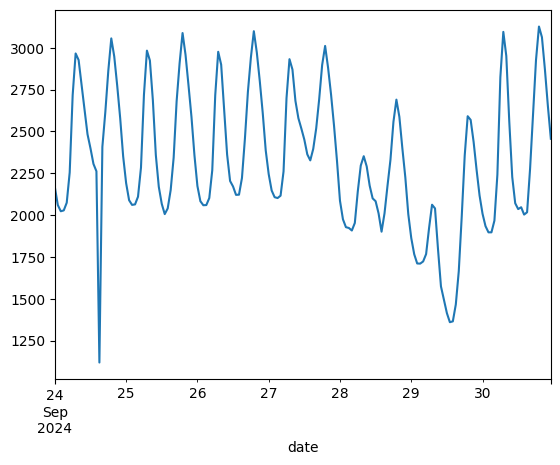

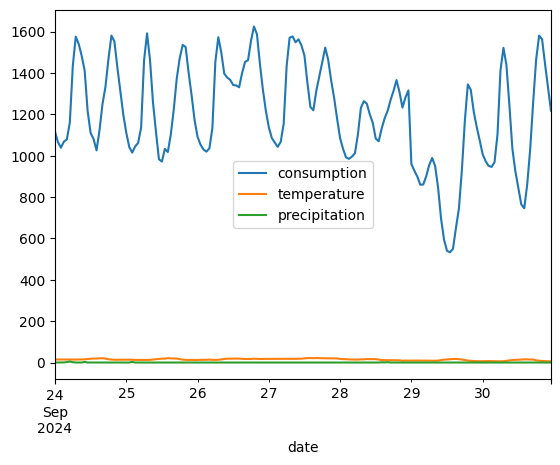

In [119]:
df_train.iloc[:, 0].tail(168).plot.line()
df_train.iloc[:, 1:4].tail(168).plot.line()

In [121]:
# scaling the training data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(df_train)

df_train_scaled = scaler.transform(df_train)
df_test_scaled = scaler.transform(df_test)

df_train_scaled

array([[0.12349263, 0.46890834, 0.23954373, ..., 0.5960461 , 0.04347826,
        0.83333333],
       [0.11299687, 0.4491018 , 0.22623574, ..., 0.5960461 , 0.08695652,
        0.83333333],
       [0.10585083, 0.43482266, 0.24714829, ..., 0.5960461 , 0.13043478,
        0.83333333],
       ...,
       [0.55180884, 0.66513128, 0.43155894, ..., 0.56794104, 0.91304348,
        0.        ],
       [0.50290308, 0.61400276, 0.42395437, ..., 0.59051129, 0.95652174,
        0.        ],
       [0.45913354, 0.56103178, 0.41254753, ..., 0.60617227, 1.        ,
        0.        ]])

In [122]:
# creating the trainX and trainY
trainX = []
trainY = []

n_future = 1 # number of hours we want to predict into the future
n_past = 168 # 168 hours, because of weekly variation

for i in range(n_past, len(df_train_scaled) - n_future + 1): # from 168 to the end without going out of bounds
	trainX.append(df_train_scaled[i - n_past:i, 0:df_train_scaled.shape[1]]) # from 168 to the end
	trainY.append(df_train_scaled[i + n_future - 1:i + n_future, 0]) # from 168 to the end

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (23898, 168, 13).
trainY shape == (23898, 1).


In [123]:
# creating the testX and testY
testX = []
testY = []

n_future = 1 # number of hours we want to predict into the future
n_past = 168 # 168 hours, because of weekly variation

for i in range(n_past, len(df_test_scaled) - n_future + 1): # from 168 to the end without going out of bounds
	testX.append(df_test_scaled[i - n_past:i, 0:df_test_scaled.shape[1]]) # from 168 to the end
	testY.append(df_test_scaled[i + n_future - 1:i + n_future, 0]) # from 168 to the end

testX, testY = np.array(testX), np.array(testY)

print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

testX shape == (623, 168, 13).
testY shape == (623, 1).


In [124]:
# defining the model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

d:\Projects\Programming\Gen-I Trading Challenge\Task 1\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 168, 64)        │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,417 (126.63 KB)

 Trainable params: 32,417 (126.63 KB)

 Non-trainable params: 0 (0.00 B)

In [125]:
from keras.callbacks import EarlyStopping # type: ignore

# fit model
# history = model.fit(trainX, trainY, epochs=100, batch_size=64, validation_split=0.1, verbose=1)

earlyStop = EarlyStopping(monitor = "val_loss", verbose = 2, mode = 'min', patience = 2)

history = model.fit(trainX, trainY, epochs=100, batch_size=32, validation_data = (testX, testY), verbose = 1, callbacks = [earlyStop])

Epoch 1/100
747/747 ━━━━━━━━━━━━━━━━━━━━ 168s 137ms/step - loss: 0.0056 - val_loss: 0.0079
Epoch 2/100
747/747 ━━━━━━━━━━━━━━━━━━━━ 104s 139ms/step - loss: 0.0014 - val_loss: 0.0049
Epoch 3/100
747/747 ━━━━━━━━━━━━━━━━━━━━ 108s 144ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 4/100
747/747 ━━━━━━━━━━━━━━━━━━━━ 159s 165ms/step - loss: 9.2649e-04 - val_loss: 0.0040
Epoch 5/100
747/747 ━━━━━━━━━━━━━━━━━━━━ 100s 134ms/step - loss: 7.6462e-04 - val_loss: 0.0028
Epoch 6/100
747/747 ━━━━━━━━━━━━━━━━━━━━ 75s 101ms/step - loss: 7.1640e-04 - val_loss: 0.0029
Epoch 7/100
747/747 ━━━━━━━━━━━━━━━━━━━━ 62s 83ms/step - loss: 6.5440e-04 - val_loss: 0.0033
Epoch 7: early stopping


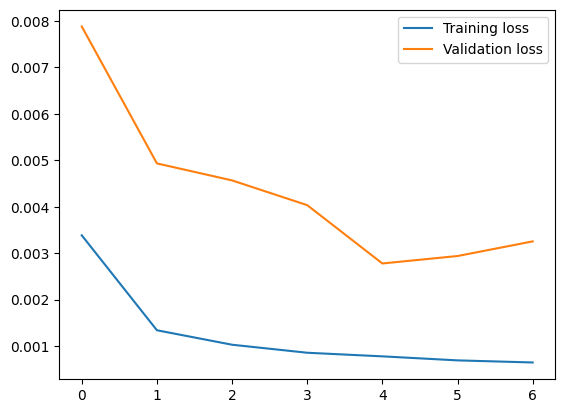

In [126]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [127]:
n_days_for_prediction = df_test.shape[0]
print(n_days_for_prediction)

791


In [128]:
# n_days_for_prediction = 72

In [129]:
predict_period_dates = pd.date_range(split_date, periods = n_days_for_prediction, freq='h').tolist()
print(predict_period_dates)

[Timestamp('2024-10-01 00:00:00'), Timestamp('2024-10-01 01:00:00'), Timestamp('2024-10-01 02:00:00'), Timestamp('2024-10-01 03:00:00'), Timestamp('2024-10-01 04:00:00'), Timestamp('2024-10-01 05:00:00'), Timestamp('2024-10-01 06:00:00'), Timestamp('2024-10-01 07:00:00'), Timestamp('2024-10-01 08:00:00'), Timestamp('2024-10-01 09:00:00'), Timestamp('2024-10-01 10:00:00'), Timestamp('2024-10-01 11:00:00'), Timestamp('2024-10-01 12:00:00'), Timestamp('2024-10-01 13:00:00'), Timestamp('2024-10-01 14:00:00'), Timestamp('2024-10-01 15:00:00'), Timestamp('2024-10-01 16:00:00'), Timestamp('2024-10-01 17:00:00'), Timestamp('2024-10-01 18:00:00'), Timestamp('2024-10-01 19:00:00'), Timestamp('2024-10-01 20:00:00'), Timestamp('2024-10-01 21:00:00'), Timestamp('2024-10-01 22:00:00'), Timestamp('2024-10-01 23:00:00'), Timestamp('2024-10-02 00:00:00'), Timestamp('2024-10-02 01:00:00'), Timestamp('2024-10-02 02:00:00'), Timestamp('2024-10-02 03:00:00'), Timestamp('2024-10-02 04:00:00'), Timestamp('20

In [130]:
prediction = model.predict(trainX[-n_days_for_prediction:])

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


In [131]:
prediction_copies = np.repeat(prediction, df_train_scaled.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

In [132]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i)

In [133]:
df_forecast = pd.DataFrame({'date':np.array(forecast_dates), 'consumption':y_pred_future})
df_forecast['date']=pd.to_datetime(df_forecast['date'])
df_forecast.index = df_forecast['date']
df_forecast = df_forecast.drop('date', axis=1)
df_forecast

,consumption
date,
2024-10-01 00:00:00,2055.663574
2024-10-01 01:00:00,1999.978149
2024-10-01 02:00:00,2010.044556
2024-10-01 03:00:00,2129.513916
2024-10-01 04:00:00,2279.535400
...,...
2024-11-02 18:00:00,2842.045654
2024-11-02 19:00:00,2823.142578
2024-11-02 20:00:00,2596.705566


In [134]:
df_test = df_test[:n_days_for_prediction]

In [135]:
df_test

,consumption_eles_forecast,consumption,temperature,precipitation,irradiation,price,volumes,cloudiness,holiday,shifted_consumption_168,shifted_consumption_48,hour,weekDay
date,,,,,,,,,,,,,
2024-10-01 00:00:00,2259.0,1149.0,5.8,0.0,0.0,3.21,842.200,80.0,0,1117.0,960.0,0,1
2024-10-01 01:00:00,2162.0,1073.0,5.6,0.0,0.0,0.07,779.600,80.0,0,1066.0,928.0,1,1
2024-10-01 02:00:00,2129.0,1048.0,5.4,0.0,0.0,0.05,708.700,80.0,0,1039.0,899.0,2,1
2024-10-01 03:00:00,2133.0,1062.0,5.3,0.0,0.0,0.02,699.900,80.0,0,1068.0,860.0,3,1
2024-10-01 04:00:00,2185.0,1060.0,4.8,0.0,0.0,0.09,847.100,80.0,0,1079.0,861.0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-02 19:00:00,1818.0,1109.0,13.8,0.0,0.0,100.83,1546.887,83.0,0,1274.0,1166.0,19,5
2024-11-02 20:00:00,1818.0,1109.0,13.8,0.0,0.0,100.83,1467.100,83.0,0,1288.0,1104.0,20,5
2024-11-02 21:00:00,1818.0,1109.0,13.8,0.0,0.0,100.83,1365.087,83.0,0,1238.0,1032.0,21,5


In [136]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error # type: ignore
from sktime.performance_metrics.forecasting import mean_squared_percentage_error # type: ignore

mse = root_mean_squared_error(df_test['consumption'], df_forecast['consumption'])
mae = mean_absolute_error(df_test['consumption'], df_forecast['consumption'])
mape = mean_absolute_percentage_error(df_test['consumption'], df_forecast['consumption'])
rmspe = mean_squared_percentage_error(df_test['consumption'], df_forecast['consumption'], square_root=True)

plt_title = 'MAE: {0:.2f}, RMSE: {1:.2f}, MAPE: {2:.2f}, RMSPE: {3:.2f}'.format(mae, mse, mape*100, rmspe*100)

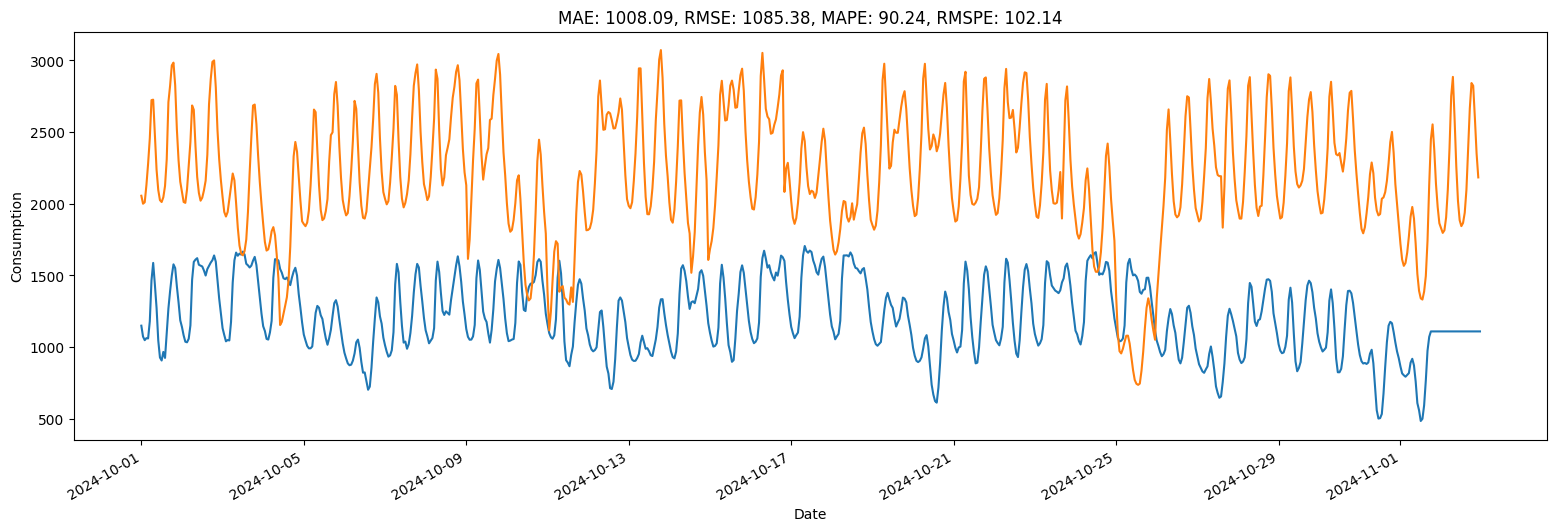

In [137]:
plt.plot(df_test['consumption'], label='Actual consumption')
plt.plot(df_forecast['consumption'], label='Predicted consumption')
# change axis date format
plt.gcf().autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.title(plt_title)
# set figsize to (19, 6)
plt.gcf().set_size_inches(19, 6)

1 <br>
MAE: 112.01, RMSE: 185.12, MAPE: 9.08, RMSPE: 15.33<br>
consumption	temperature	precipitation	irradiation	cloudiness	holiday	shifted_consumption_168	shifted_consumption_48	hour	weekDay

2 <br>
MAE: 127.40, RMSE: 193.21, MAPE: 10.17, RMSPE: 15.69<br>
consumption	temperature	precipitation	irradiation	cloudiness	holiday

3 <br>
MAE: 112.07, RMSE: 179.88, MAPE: 8.98, RMSPE: 14.47<br>
consumption	temperature

In [102]:
# df_forecast.to_csv('forecasts/forecast_LTSM_3.csv', index=False)